0
/Users/nmueller/Documents/github/Recombination-Material/Applications/combined/229e_all.tree


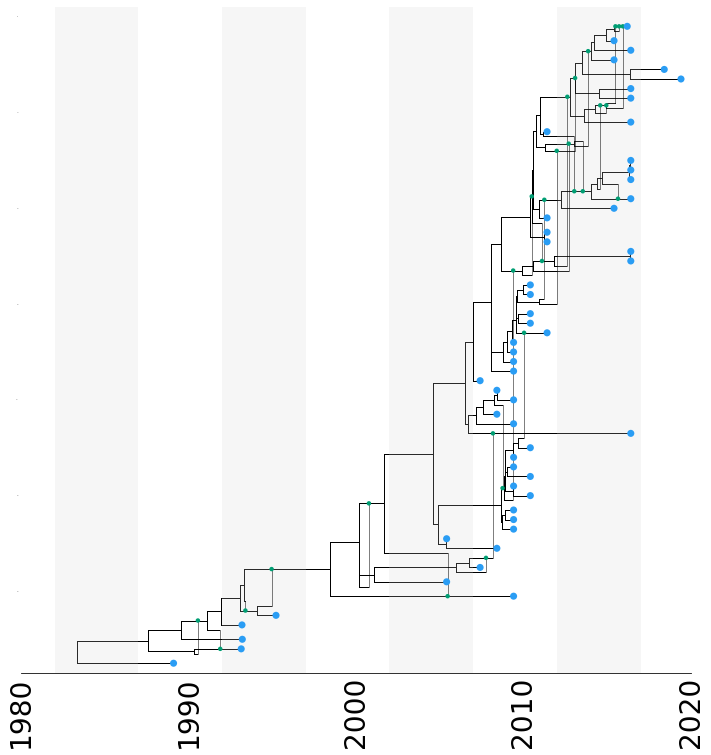

1
/Users/nmueller/Documents/github/Recombination-Material/Applications/combined/oc43_all.tree


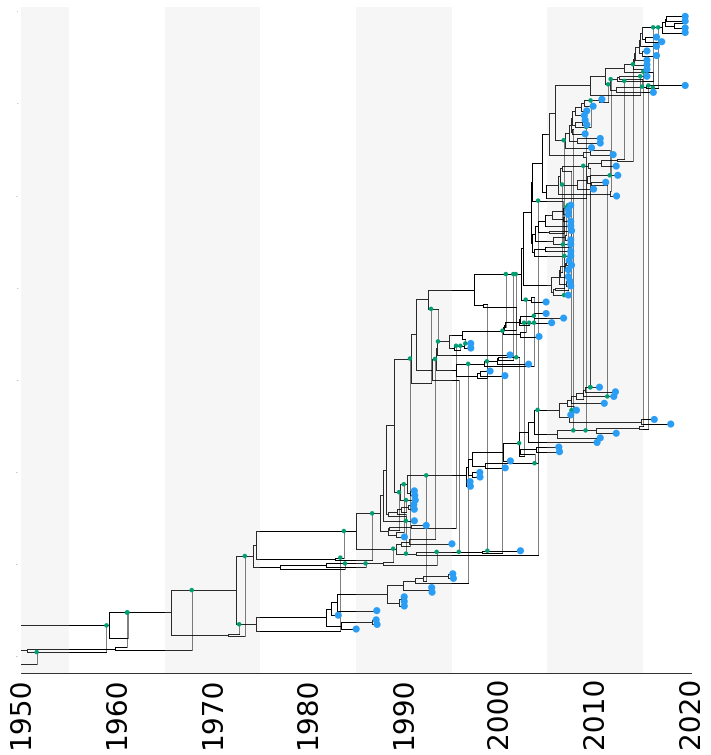

2
/Users/nmueller/Documents/github/Recombination-Material/Applications/combined/nl63_all.tree


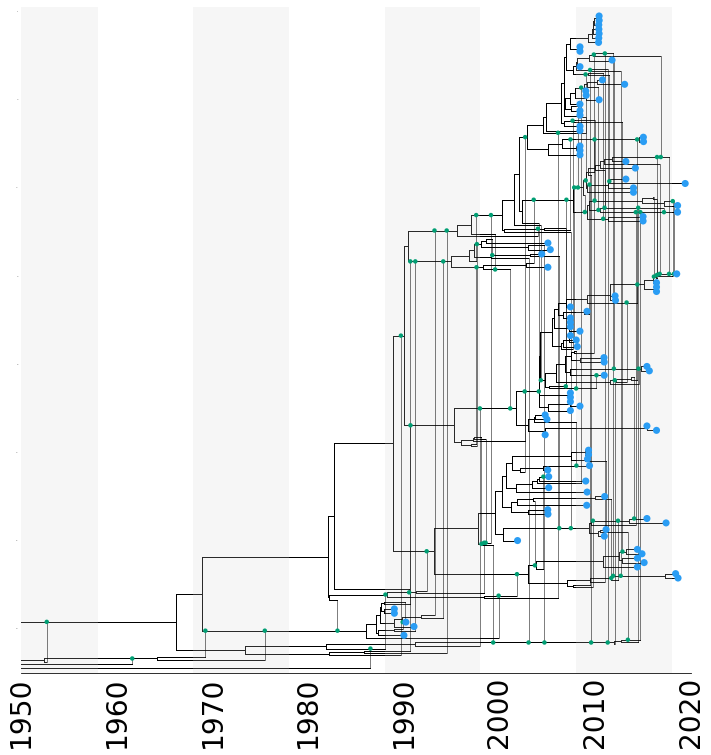

3
/Users/nmueller/Documents/github/Recombination-Material/Applications/combined/mers_all.tree


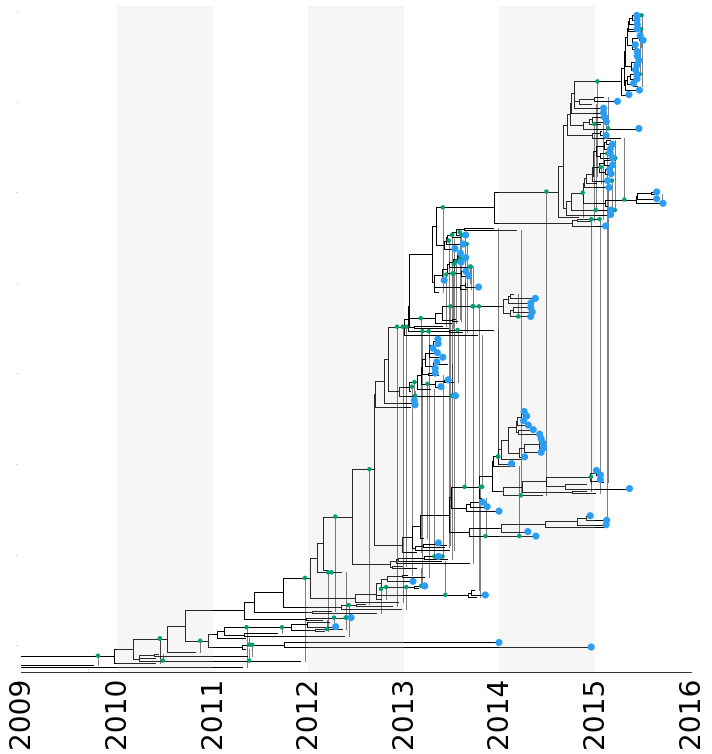

4
/Users/nmueller/Documents/github/Recombination-Material/Applications/combined/sars-like_all.tree


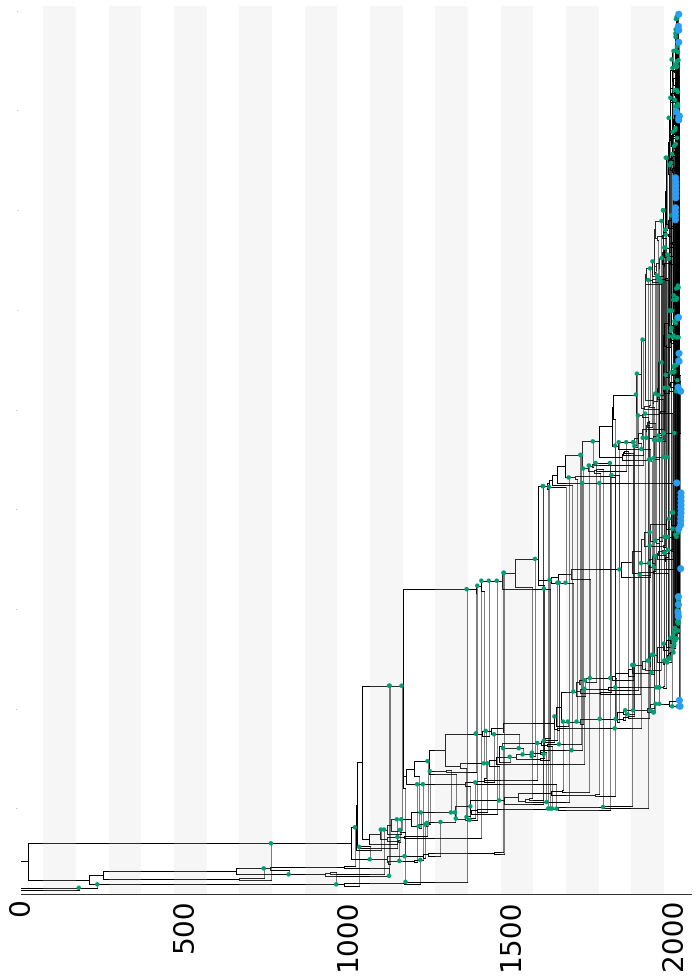

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
from scipy.stats import gaussian_kde

## set default matplotlib font and font size
typeface='normal'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

import imp,os
from itertools import permutations

bt=imp.load_source('baltic_bacter','/Users/nmueller/Documents/github/Recombination-Material/Applications/visualisation_code/baltic_bacter.py')

segments=['PB2','PB1','PA','HA','NP','NA','MP','NS']
translate={i:segments.index(x) for i,x in enumerate(sorted(segments))}

colourSwitches=[mpl.cm.Greys(i) for i in np.linspace(0.4,0.8,3)]

colours={'PB1':(0.2981622478541206, 0.44644367598435458, 0.64719724652229571),
        'PB2':(0.28098424626331703, 0.63955403192370541, 0.39507882933990629),
        'PA':(0.8162552973803352, 0.41062668737243202, 0.29078047883276847),
        'HA':(0.88366013765335083, 0.77908497055371606, 0.18562091886997223),
        'NP':(0.8, 0.4745098039215686, 0.6549019607843137),
        'NA':(0.4666666666666667, 0.7450980392156863, 0.8588235294117647),
        'MP':(0.49803923567136127, 0.43267975250879925, 0.52287583549817396),
        'NS':(0.8, 0.7552941176470589, 0.5929411764705883)}

virus=['229e','oc43', 'nl63','mers', 'sars-like']
virusname=['229e_all','oc43_all', 'nl63_all','mers_all', 'sars-like_all']

interval = [5, 10, 10, 1, 100]

maxHeight = [-1,-1,-1,0]

figsizex = [12, 12, 12, 12, 12]
figsizey = [15, 15, 15, 15, 20]

start = [1980,1950,1950,2009,0]
end = [2020, 2020,2020,2016,2050]

for v in range(len(virus)):
    print(v)

    path='/Users/nmueller/Documents/github/Recombination-Material/Applications/combined/'
    fname= virusname[v] + '.tree'

    tree_path=os.path.join(path,fname)
    print(tree_path)

    ll=bt.loadNexus(tree_path,date_fmt='%Y-%m-%d',verbose=False) ## load tree
    ll.drawTree()

    fig = plt.figure(figsize=(figsizex[v], figsizey[v]),facecolor='w') ## new figure
    # gs = gridspec.GridSpec(2,2,height_ratios=[1,4],width_ratios=[1,4],wspace=0.1,hspace=0.1) 
    gs = gridspec.GridSpec(2,2,height_ratios=[1,6],width_ratios=[1,4],wspace=0.2,hspace=0.1) 

    ax=plt.subplot(gs[1,0:],facecolor='w') ## first subplot - tree

    # for i in range(len(colours)):
    #     seg=segments[i]
    #     ax.text(0.05,0.75-i/23.0,seg,size=42,color=colours[seg],transform=ax.transAxes,fontdict={'family':'Arial'}) ## plot segment colour legend

    posteriorCutoff=lambda k: 1.0>0.0 ## define cutoff for removing reassortment events

    keep=set(list(filter(posteriorCutoff,ll.getBranches(lambda k: isinstance(k,bt.reticulation))))+ll.getExternal(lambda k: isinstance(k,bt.leaf))) ## remove reassortment at a given cutoff

    ll=ll.reduceTree(keep) ## reduce tree down to those that pass posterior cutoff
    
    maxLength = 0
    for k in ll.Objects:
        k.traits['re']=0
        maxLength=max(maxLength, k.traits['length'])

    for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
        if hasattr(k,'contribution'): ## if branch is the result of reassortment
            subtree=ll.traverse_tree(k.children[-1],include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
            for w in subtree: ## for every branch in subtree
                if posteriorCutoff(k.contribution): ## if it's a branch that passes a posterior threshold
                    w.traits['re']=max([w.traits['re']+1,k.contribution.traits['re']+1]) ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)

    for k in ll.Objects: ## iterate over branches
        x=k.absoluteTime
        xp=k.parent.absoluteTime
        y=k.y
        
        lineweight = k.traits['length']/maxLength*2

        lineweight =1
        

        col=colourSwitches[k.traits['re']%len(colourSwitches)] ## colour cycles through range defined at the beginning
    #     mostReassortments=max([w.traits['re'] for w in ll.Objects if 're' in w.traits])
    #     norm=mpl.colors.Normalize(-mostReassortments/3,mostReassortments)
    #     col=mpl.cm.Greys(norm(k.traits['re']))
    #                 print(col)

        if isinstance(k,bt.reticulation)==False: ## if a regular branch - colour based on number of reassortments from root
            ax.plot([x,xp],[y,y],color='k',lw=lineweight,zorder=0)
        else:
            ax.plot([x,xp],[y,y],color='k',lw=lineweight,ls='-',zorder=0) ## reassortment branches are black

        if k.branchType=='node': ## if node - plot vertical bar
            left,right=k.children[-1].y,k.children[0].y
            lineweightl = 1# k.children[-1].traits['length']/maxLength*2
            lineweightr = 1 #k.children[0].traits['length']/maxLength*2

            
            ax.plot([x,x],[left,(right+left)/2],color='k',lw=lineweightl,zorder=0)
            ax.plot([x,x],[(right+left)/2,right],color='k',lw=lineweightr,zorder=0)
        elif isinstance(k,bt.leaf): ## if actual leaf - add circle
            ax.scatter(x,y,s=50,facecolor='#2a9df4',edgecolor='none',zorder=4)
            #ax.scatter(x,y,s=40,facecolor='#D55E00',edgecolor='none',zorder=3)

        elif isinstance(k,bt.reticulation): ## dealing with reassortant branch
            #if posteriorCutoff(k): ## passes posterior threshold
            #segs=sorted(map(int,k.traits['length'])) ## get travelling segment(s)

            c='k'
            s=20
            #for i in range(len(segs)):
            #    name=segments[translate[segs[i]]] ## get name of segment
            #    c=colours[name] ## get appropriate colour
            #    o=1/20.
            i=1
            o=1/20

            ax.plot([x+o*i,x+o*i],[y,k.target.y],color="k",lw=lineweight,alpha=0.5,ls='-',zorder=1) ## plot vertical lineage leaving donor and heading to recipient
            ax.scatter(x+o*i,k.target.y,s=20,facecolor='#009E73',edgecolor='none',zorder=3) ## plot circles
            ax.scatter(x+o*i,k.target.y,s=lineweight,facecolor='k',edgecolor='none',zorder=2)

    [ax.spines[loc].set_visible(False) for loc in ax.spines if loc!='bottom'] ## remove axis spines
    # [ax.axvline(i,ls='-',color='lightgrey',lw=1,alpha=0.2) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),1)] ## add timeline
    timewidth=interval[v]
    [ax.axvspan(i,i+timewidth,facecolor='lightgrey',edgecolor='none',alpha=0.2) for i in range(int(ll.root.absoluteTime-1),int(ll.root.absoluteTime+ll.treeHeight+1),2*timewidth)] ## add timeline

    ax.tick_params(axis='y',size=0,labelsize=0)
    ax.tick_params(axis='x',size=0,labelsize=28, rotation=90)
    ax.set_ylim(-1,ll.ySpan+1)
    ax.set_xlim(start[v],end[v])

    plt.gca().invert_yaxis()
    plt.show()
    figname =  '/Users/nmueller/Documents/github/Recombination-Text/Figures/networks/' + virus[v] + '.pdf'
    fig.savefig(figname, bbox_inches='tight')
    plt.close(fig)
    
